# Espectro de potencia y fase de una traza sísmica sintética


### Parte 1
Partiendo de la filosofía de [reproducibilidad](http://www.ahay.org/wiki/Reproducibility?setlang=es) computacional en ciencias de la tierra ([también ver aquí](http://www.journals.unam.mx/index.php/ingenieria/article/view/30838)),  este ejercicio tiene por objetivo calcular una traza sintética y su espectro de potencia y fase del pozo F03-4 del conjunto de datos libres _[Netherlands Offshore F3 Block](http://www.opendtect.org/osr/Main/NetherlandsOffshoreF3BlockComplete4GB)_. He adaptado y modificado parte de la secuencia de comandos de [Bianco (2014)](https://library.seg.org/doi/10.1190/tle33060674.1). 

Esta primera parte contiene la lectura de los datos del registro geofísico compuesto del pozo F03-4, exportado de [OpendTect](https://dgbes.com/) en formato csv, y el cálculo del sismograma sintético a partir de una ondícula de Ricker de 25 Hz de fase cero. El archivo en formato LAS se puede encontrar [aquí.](http://www.nlog.nl/nlog/requestData/nlogp/allBor/metaData.jsp?tableName=BorLocation&id=106523731) 
En una segunda parte abordaré nociones básicas de la Tranformada de Fourier Discreta y su aplicación en el cálculo del espectro de potencia y fase de la traza sísmica calculada en esta primera parte.  

In [1]:
%matplotlib inline
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
reg=pd.read_csv('Well_F03-4.csv')
reg.columns

Index(['Depth', 'Density', 'P_Slowness', 'Gamma_Ray', 'Porosity_Frac',
       'P_Impedance', 'P_Impedance-rel'],
      dtype='object')

In [3]:
reg[['Depth', 'Density', 'P_Slowness', 'Gamma_Ray', 'Porosity_Frac','P_Impedance', 'P_Impedance-rel']].describe()

,Depth,Density,P_Slowness,Gamma_Ray,Porosity_Frac,P_Impedance,P_Impedance-rel
count,12467.000000,12467.000000,12467.000000,12467.000000,12467.000000,1.246700e+04,12467.000000
mean,949.909211,1671.126495,-2513.370321,-171.674114,-371.025110,4.253690e+06,1439.670555
std,548.496334,2292.885303,4735.577767,1462.328306,1890.949234,9.532833e+05,105585.123392
min,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9.999000e+03,-368205.031300
25%,474.954600,2078.474350,-9999.000000,28.750000,0.297250,4.090630e+06,-37871.101600
50%,949.909200,2120.100000,453.723100,43.709600,0.327600,4.376170e+06,42.011800
75%,1424.863850,2167.600000,500.202300,61.150000,0.352700,4.738070e+06,47294.103550
max,1899.818500,2310.277300,594.700300,104.350000,0.452500,6.139820e+06,504566.000000


In [4]:
print ('Tipo de dato de la columna P_Slowness : ',type(reg['P_Slowness']))

Tipo de dato de la columna P_Slowness :  <class 'pandas.core.series.Series'>


In [5]:
z = reg['Depth'] # Metros
den = reg['Density'] # g/cm3
dtco = reg['P_Slowness'] #us/m
gr = reg['Gamma_Ray'] #API
phi = reg['Porosity_Frac'] #[1]

Para obtener la relación de conversión profundidad a tiempo, debemos hacer la suma acumulada del registro sónico (tacum), a partir del intervalo de tiempo donde inicia el registro sónico. Para ello, a partir de la visualización de los datos en OpendTect se tiene el intervalo de inicio (tini) a partir de 500 ms, señalado con la flecha de color blanco en la imagen inferior.

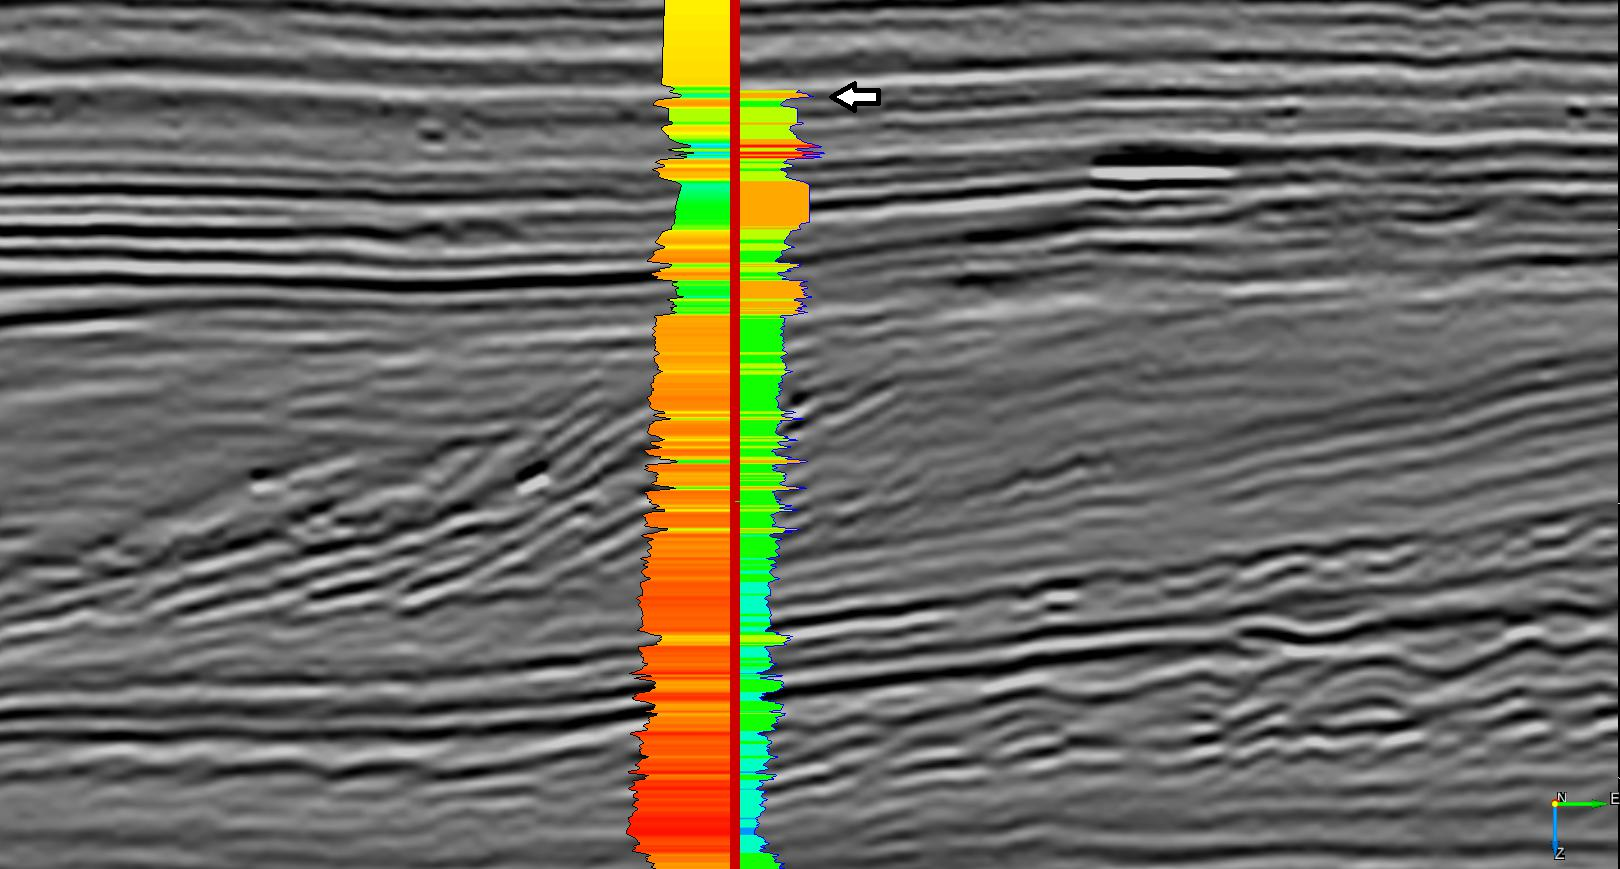

In [6]:
Image(filename='Well_F03-4.png', width=500, height=600)

Intervalo de interés en profundidad

In [7]:
z = z[3298:12201]

In [8]:
tini = 0.5
sca_dt = 0.1524 * np.nan_to_num(dtco[3298:12201]) / 1e6
tacum = tini + 2 * np.cumsum(sca_dt)

In [9]:
print('Tiempo total = ', max(np.round(tacum,2)),'[s]')

Tiempo total =  1.81 [s]


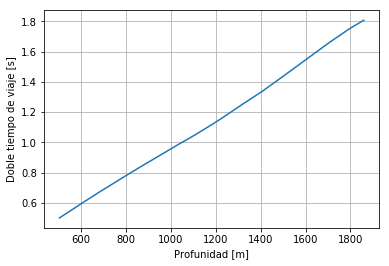

In [10]:
_ = plt.plot(z, tacum)
_ = plt.xlabel('Profunidad [m]')
_ = plt.ylabel('Doble tiempo de viaje [s]')
_ = plt.grid(True)

Impedancia acústica en el dominio de la profundidad

In [11]:
imp = den[3298:12201]*1e6/dtco[3298:12201]

In [12]:
imp = imp.values

In [13]:
print('Tipo de dato de imp : ',type(imp))

Tipo de dato de imp :  <class 'numpy.ndarray'>


Serie de coeficientes de reflectividad de la profundidad

In [14]:
scr = (imp[1:] - imp[:-1]) / (imp[1:] + imp[:-1])

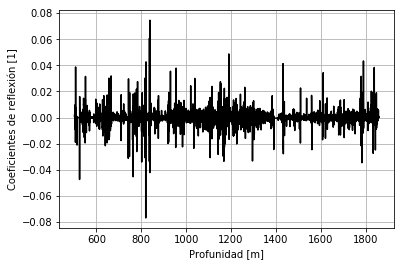

In [15]:
_ = plt.plot(z[:-1], scr, 'k')
_ = plt.xlabel('Profunidad [m]')
_ = plt.ylabel('Coeficientes de reflexión [1]')
_ = plt.grid(True)

Conversión de la impendancia acústica al dominio del tiempo (impt) a través de la función de interpolación [np.interp](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.interp.html)

In [16]:
dt = 0.004 #Intervalo de muestreo
maxt = 1.81 # Tiempo total
t = np.arange(0.5, maxt, dt) 

In [17]:
impt = np.interp(x = t, xp = tacum, fp = imp)

Serie de coeficientes de reflexión en el dominio del tiempo (scrt)

In [18]:
scrt = (impt[1:] - impt[:-1]) / (impt[1:] + impt[:-1]) 

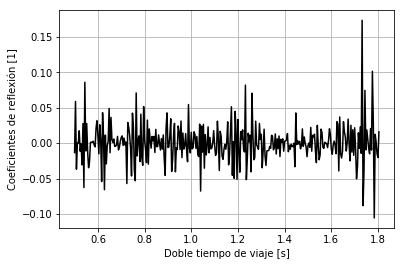

In [19]:
_ = plt.plot(t[:-1], scrt, 'k')
_ = plt.xlabel('Doble tiempo de viaje [s]')
_ = plt.ylabel('Coeficientes de reflexión [1]')
_ = plt.grid(True)

Lentitud de onda P en el dominio del tiempo (dtcot)

In [20]:
dtcot = np.interp(x = t, xp = tacum, fp = dtco[3298:12201])

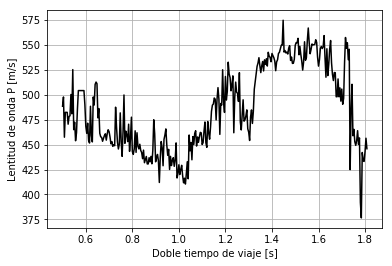

In [21]:
_ = plt.plot(t, dtcot, 'k')
_ = plt.xlabel('Doble tiempo de viaje [s]')
_ = plt.ylabel('Lentitud de onda P [m/s]')
_ = plt.grid(True)

Ondícula de Ricker

In [22]:
def ricker(frec, lon, dt):
    t = np.arange(-lon / 2, (lon-dt) / 2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(frec**2)*(t**2))*np.exp(-(np.pi**2)*(frec**2)*(t**2))
    return t, y

In [23]:
tw, wt = ricker(frec=25, lon = 248e-3, dt = 4e-3) # tw:tiempo ondícula, wt:ondícula

In [24]:
tss = np.convolve(wt, scrt, mode='same') # tss:traza sísmica sintética

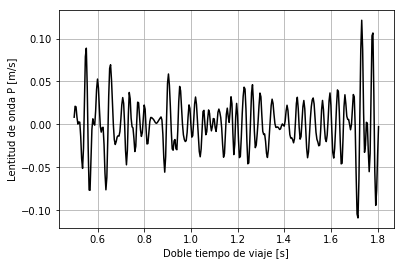

In [25]:
_ = plt.plot(t[:-1], tss, 'k')
_ = plt.xlabel('Doble tiempo de viaje [s]')
_ = plt.ylabel('Lentitud de onda P [m/s]')
_ = plt.grid(True)

Integración de resultados

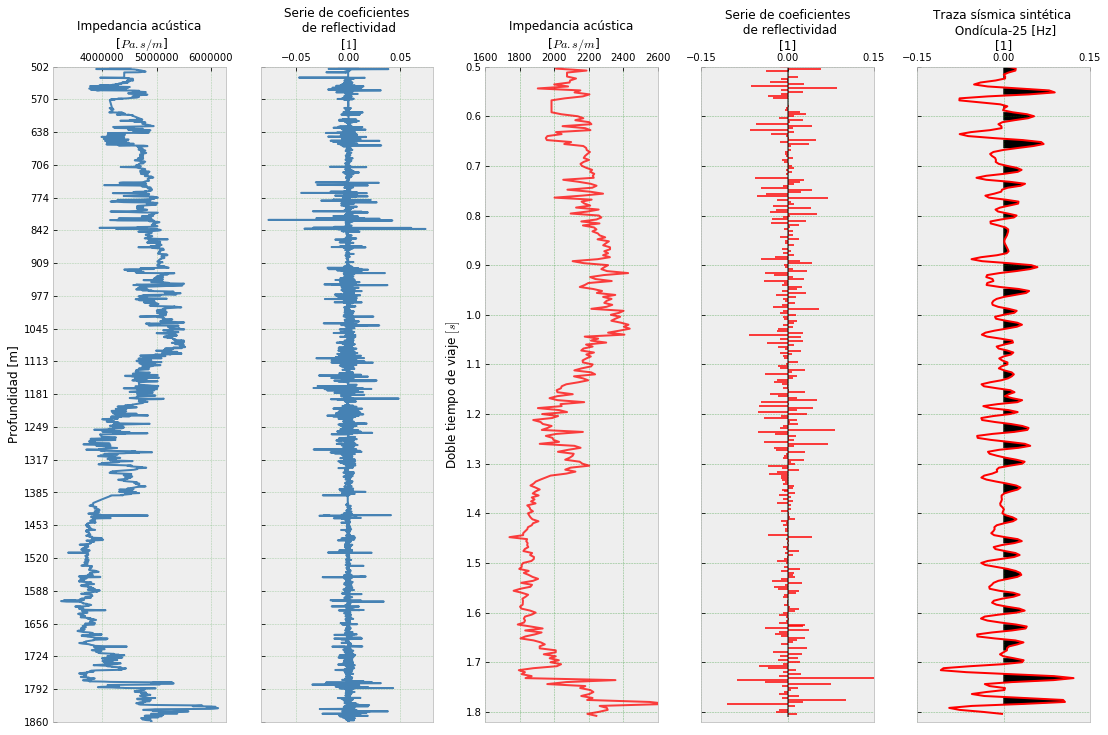

In [26]:
################################
f1 = plt.figure(figsize = [12,13])
plt.style.use('bmh')

################################
################################

# Impedancia acústica en el dominio de la profundidad
curv1 = f1.add_axes([0, 0, 0.2,0.7]) #Define la posición del carril [abscisa al origen, ordenada al origen, ancho, alto]
curv1.plot(den[3298:12201]*1e6/dtco[3298:12201], z,'steelblue', alpha=1, lw=2)
curv1.set_xlabel('Impedancia acústica\n '+ '[$Pa.s/m$]', fontsize = '12' )
curv1.set_ylabel('Profundidad ' + '[m]', fontsize = '12' )
curv1.set_ylim(502.6152, 1859.4324)
#curv1.set_xlim(1600, 2600)
curv1.set_yticks(np.linspace (502,1860,21) )
curv1.xaxis.tick_top()
curv1.xaxis.set_label_position('top')
curv1.invert_yaxis()
curv1.grid(True, c="g", alpha=0.3)

# Serie de reflectividad en el dominio de la profundidad
curv2 = f1.add_axes([0.24, 0, 0.2,0.7]) 
curv2.plot(scr, z[:-1],'steelblue', alpha=1, lw=2)
curv2.set_xlabel('Serie de coeficientes\n de reflectividad\n '+ '[$1$]', fontsize = '12' )
curv2.set_ylim(502.6152, 1859.4324)
#curv3.set_xlim(2000, 2300)
curv2.set_yticks(np.linspace (502,1860,21))
curv2.set_yticklabels('')
curv2.xaxis.tick_top()
curv2.xaxis.set_label_position('top')
curv2.invert_yaxis()
curv2.grid(True, c="g", alpha=0.3)

# Impedancia acústica en el dominio del tiempo
curv3 = f1.add_axes([0.50, 0.0, 0.2, 0.7])
curv3.plot(1e6/dtcot, t,'r', alpha=0.75, lw=2)
curv3.set_xlabel('Impedancia acústica\n ' + '[$Pa.s/m$]' , fontsize ='12' )
curv3.set_ylabel('Doble tiempo de viaje ' + '$[s]$', fontsize = '12' )
curv3.set_ylim(0.500, 1.82)
curv3.set_xlim(1600, 2600)
#curv5.set_xticks(np.linspace(0, 2*1e4, 5))
curv3.set_yticks(np.linspace(0.5 , 1.8, 14))
curv3.xaxis.tick_top()
curv3.xaxis.set_label_position('top')
curv3.invert_yaxis()
curv3.grid(True, c="g", alpha=0.5)

# Serie de coeficientes de reflectividad en el dominio del tiempo
curv4 = f1.add_axes([0.75, 0.0, 0.2, 0.7])
curv4.hlines(t[:-1], 0, scrt, color='r', alpha= 0.75, lw = 2 )                
curv4.plot([0, 0], [t.min(), t.max()], '-', c='k', alpha = 0.5)   
curv4.set_xlabel('Serie\n de\n reflectividad\n' + '[1]', fontsize ='12' )
curv4.set_xlabel('Serie de coeficientes\n de reflectividad\n' + '[1]', fontsize ='12' )
curv4.set_ylim(0.500, 1.82)
curv4.set_xlim(-0.15, 0.15)
curv4.set_yticklabels('')
curv4.xaxis.tick_top()
curv4.set_yticks(np.linspace(0.5 , 1.8, 14))
curv4.set_xticks([-0.15, 0, 0.15] )
curv4.xaxis.set_label_position('top')
curv4.invert_yaxis()
curv4.grid(True, c="g", alpha=0.5)

#Traza sísmica sintética sintética en el dominio del tiempo
tamp = t[:-1]
curv5 = f1.add_axes([1.0, 0.0, 0.2, 0.7])
curv5.plot(tss, tamp,'r')
curv5.fill_betweenx(t[:-1], tss,  0,  tss > 0.0,  color='k', alpha = 1.0)
curv5.set_xlabel('Traza sísmica sintética \n Ondícula-25 [Hz]\n' + '[1]', fontsize ='12' )
curv5.set_ylim(0.500, 1.82)
curv5.set_xlim(-0.15, 0.15)
curv5.set_yticklabels('')
curv5.xaxis.tick_top()
curv5.set_yticks(np.linspace(0.5 , 1.8, 14))
curv5.set_xticks([-0.15, 0, 0.15] )
curv5.xaxis.set_label_position('top')
curv5.invert_yaxis()
curv5.grid(True, c="g", alpha=0.5)

plt.show()


In [27]:
#Exportar
np.savetxt("Traza_sísmica-25Hz.csv", np.column_stack((tamp,tss)), delimiter=",", fmt='%s')